
The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

Dataset [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).



In [1]:
# importing libraries
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# reading dataset
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Preparing the dataset 

For this homework, we only want to use a subset of data. 

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

In [3]:
# missing value
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [4]:
df.fillna(0, inplace=True)

In [5]:
# Filter the DataFrame to keep only the desired values
filtered_df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
filtered_df['ocean_proximity'].unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

In [6]:
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


### Split the dataset

* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Apply the log transformation to the `median_house_value` variable using the `np.log1p()` function.


In [7]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(filtered_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

Using DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [9]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
val_dicts = df_val.fillna(0).to_dict(orient='records')

In [10]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

#### Question 1.

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

In [11]:
# Training the regression model
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



### Question 2

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional-to make training faster)

In [13]:
# Training random forest model
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
    

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [14]:
# calculating RMSE

y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24459962783255346

### Question 3

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.


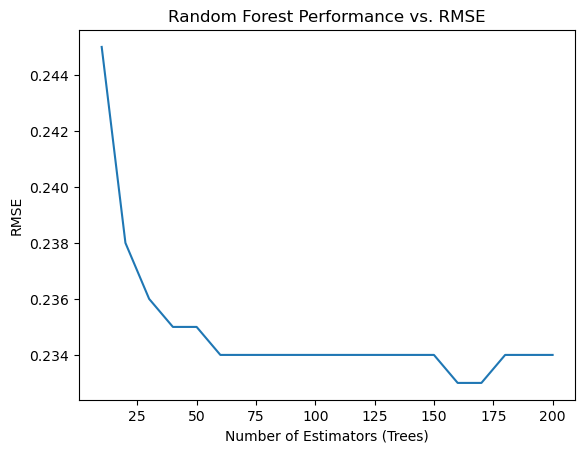

In [15]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))
    
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

# Add labels and a title
plt.xlabel("Number of Estimators (Trees)")
plt.ylabel("RMSE")
plt.title("Random Forest Performance vs. RMSE")

# Show the plot
plt.show()

### Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values,
    * try different values of n_estimators from 10 till 200 (with step 10)
    * calculate the mean RMSE
- Fix the random seed: random_state=1

In [16]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

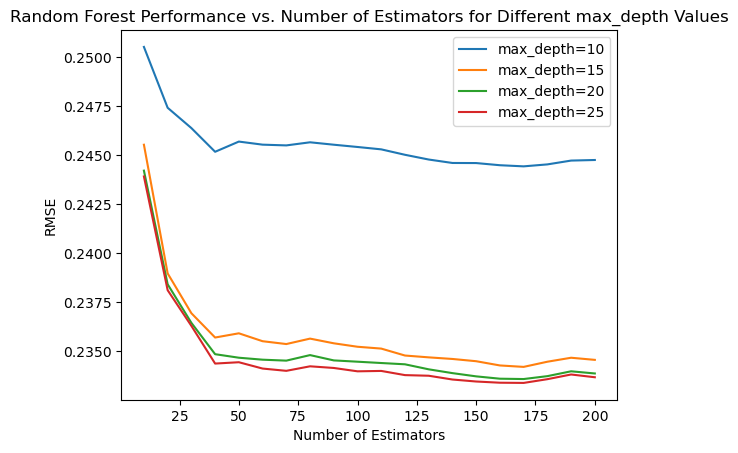

In [17]:
# Loop through different max_depth values for visualization
for d in [10, 15, 20, 25]:
    # Extract data for the current max_depth value
    df_subset = df_scores[df_scores.max_depth == d]
    
    # Plot RMSE scores against n_estimators, adding a label for the legend
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)

# Add labels and a title to the plot
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.title("Random Forest Performance vs. Number of Estimators for Different max_depth Values")

# Display the legend to identify each line
plt.legend()

### Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


In [18]:
# Training the random forest model
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [19]:
# Getting the feature importance from the model
rf.feature_importances_

array([0.01504314, 0.03006329, 0.10266505, 0.08585341, 0.33548579,
       0.21881985, 0.14745955, 0.02811472, 0.01543366, 0.02106153])

In [20]:
    df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.335486
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
2,latitude,0.102665
3,longitude,0.085853
1,housing_median_age,0.030063
7,population,0.028115
9,total_rooms,0.021062
8,total_bedrooms,0.015434
0,households,0.015043


### Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.


In [21]:
!pip install xgboost

In [22]:
import xgboost as xgb

In [23]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [24]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [25]:
# Defining the function

def parse_xgb_output(output):
    results = []  # Initialize an empty list to store the parsed results

    # Split the captured output by newlines to process each line
    for line in output.stdout.strip().split('\n'):
        # Split each line into iterations, training AUC, and validation AUC
        it_line, train_line, val_line = line.split('\t')

        # Extract the iteration number (it) by removing square brackets
        it = int(it_line.strip('[]'))

        # Extract the training AUC (train) by parsing the line
        train = float(train_line.split(':')[1])

        # Extract the validation AUC (val) by parsing the line
        val = float(val_line.split(':')[1])

        # Append the parsed values as a tuple to the results list
        results.append((it, train, val))

    # Define column names for the results DataFrame
    columns = ['num_iter', 'train_auc', 'val_auc']

    # Create a Pandas DataFrame from the parsed results
    df_results = pd.DataFrame(results, columns=columns)

    return df_results

In [30]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [31]:
# saving

key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [32]:
scores.keys()

dict_keys(['eta=0.1', 'eta=0.3'])

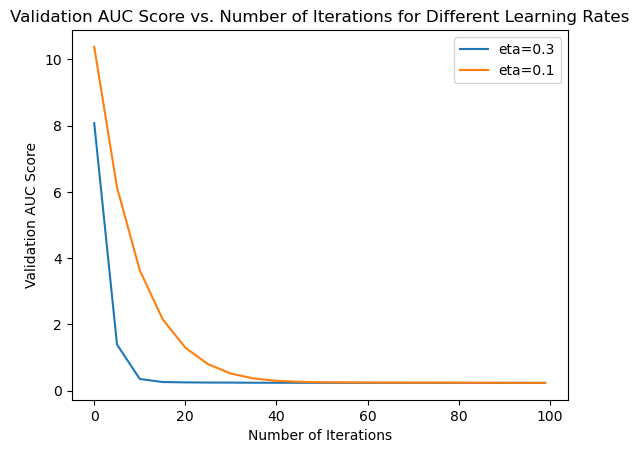

In [33]:
# List of different learning rates (etas)
etas = ['eta=0.3', 'eta=0.1']

# Loop through the different etas and plot validation AUC scores
for eta in etas:
    # Select the DataFrame for the current learning rate
    df_score = scores[eta]
    
    # Plot validation AUC scores from the DataFrame, adding a label
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

# Add labels and a title to the graph
plt.xlabel("Number of Iterations")
plt.ylabel("Validation AUC Score")
plt.title("Validation AUC Score vs. Number of Iterations for Different Learning Rates")

# Display the legend to identify each line according to the learning rate
plt.legend()

# Show the plot
plt.show()